In [ ]:
# Dataset to feed transformers
!wget https://gist.githubusercontent.com/jsdario/6d6c69398cb0c73111e49f1218960f79/raw/8d4fc4548d437e2a7203a5aeeace5477f598827d/el_quijote.txt

--2024-02-21 12:03:28--  https://gist.githubusercontent.com/jsdario/6d6c69398cb0c73111e49f1218960f79/raw/8d4fc4548d437e2a7203a5aeeace5477f598827d/el_quijote.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1060259 (1.0M) [text/plain]
Saving to: ‘el_quijote.txt.1’

el_quijote.txt.1    100%[===================>]   1.01M  --.-KB/s    in 0.04s   

2024-02-21 12:03:28 (27.0 MB/s) - ‘el_quijote.txt.1’ saved [1060259/1060259]



In [ ]:
with open('el_quijote.txt', 'r', encoding = 'utf-8') as f:
  text = f.read()

In [ ]:
print("Length of dataset in characters is: ", len(text))

Length of dataset in characters is:  1038397


In [ ]:
example = text[:24]
print(example)

DON QUIJOTE DE LA MANCHA


In [ ]:
# List and number of unique characters that occur in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"'(),-.0123456789:;<?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijlmnopqrstuvxyz¡«»¿̀́̃̈–‘’“”
89


In [ ]:
# Create a mapping from characters to integers
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

print(encode(example))
print(decode(encode(example)))

[27, 38, 37, 1, 40, 44, 32, 33, 38, 43, 28, 1, 27, 28, 1, 35, 24, 1, 36, 24, 37, 26, 31, 24]
DON QUIJOTE DE LA MANCHA


In [ ]:
# We store the encoded data in a torch tensor for simplifying future work
import torch
data = torch.tensor(encode(text), dtype = torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1038397]) torch.int64
tensor([27, 38, 37,  1, 40, 44, 32, 33, 38, 43, 28,  1, 27, 28,  1, 35, 24,  1,
        36, 24, 37, 26, 31, 24,  0, 36, 60, 58, 71, 56, 62,  1, 55, 56,  1, 26,
        56, 68, 72, 52, 64, 70, 56, 69,  1, 42, 52, 52, 72, 56, 55, 68, 52,  0,
         0, 39, 41, 32, 36, 28, 41, 24,  1, 39, 24, 41, 43, 28,  0, 26, 24, 39,
        32, 81, 43, 44, 35, 38,  1, 11, 20,  1, 40, 71, 56,  1, 70, 68, 52, 70,
        52,  1, 55, 56,  1, 62, 52,  1, 54, 65])


In [ ]:
# Now we split the data into train and test datasets
n = int(0.9*len(data))
train_data = data[:n]
test_data = data[n:]

In [ ]:
block_size = 8
train_data[:block_size+1]

tensor([27, 38, 37,  1, 40, 44, 32, 33, 38])

In [ ]:
x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
  context = x[:t+1]
  target = y[t]
  print(f"When input is {context} the output is: {target}")

When input is tensor([27]) the output is: 38
When input is tensor([27, 38]) the output is: 37
When input is tensor([27, 38, 37]) the output is: 1
When input is tensor([27, 38, 37,  1]) the output is: 40
When input is tensor([27, 38, 37,  1, 40]) the output is: 44
When input is tensor([27, 38, 37,  1, 40, 44]) the output is: 32
When input is tensor([27, 38, 37,  1, 40, 44, 32]) the output is: 33
When input is tensor([27, 38, 37,  1, 40, 44, 32, 33]) the output is: 38


In [ ]:
torch.manual_seed(1337)
batch_size = 4 # How many indepentent sequences will be processed in parallel
block_size = 8 # Maximum context length for predictions

def get_batch(split):
  # Generate a small batch of data of inputs x and targets y
  data = train_data if split == 'train' else test_data
  ix = torch.randint(len(data)-block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])
  return x,y

xb, yb = get_batch('train')
print('inputs')
print(xb.shape)
print(xb)
print('targets')
print(yb.shape)
print(yb)
print('\n----------\n')

for b in range(batch_size):
  for t in range(block_size):
    context = xb[b][:t+1]
    target = yb[b][t]
    print(f"When input is {context} then the target is: {target}")

inputs
torch.Size([4, 8])
tensor([[70, 52, 55,  1, 55, 56,  1, 66],
        [ 7,  1, 54, 65, 64,  1, 56, 62],
        [60,  1, 52,  1, 63, 60, 81,  1],
        [54, 52, 68, 52,  7,  1, 64, 60]])
targets
torch.Size([4, 8])
tensor([[52, 55,  1, 55, 56,  1, 66, 52],
        [ 1, 54, 65, 64,  1, 56, 62,  1],
        [ 1, 52,  1, 63, 60, 81,  1, 63],
        [52, 68, 52,  7,  1, 64, 60,  1]])

----------

When input is tensor([70]) then the target is: 52
When input is tensor([70, 52]) then the target is: 55
When input is tensor([70, 52, 55]) then the target is: 1
When input is tensor([70, 52, 55,  1]) then the target is: 55
When input is tensor([70, 52, 55,  1, 55]) then the target is: 56
When input is tensor([70, 52, 55,  1, 55, 56]) then the target is: 1
When input is tensor([70, 52, 55,  1, 55, 56,  1]) then the target is: 66
When input is tensor([70, 52, 55,  1, 55, 56,  1, 66]) then the target is: 52
When input is tensor([7]) then the target is: 1
When input is tensor([7, 1]) then the 

# Basic Model: Biagram Language Model

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BiagramLanguageModel(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    # Each token directly reads off the logit for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

  def forward(self, idx, targets=None):

    # idx and targets are both (B,T) tensor of integers
    logits = self.token_embedding_table(idx) # (B,T,C)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B,T) array of indices in the current context
    for _ in range(max_new_tokens):
      # get the predictions
      logits, loss = self(idx)
      # focus only on the last time step
      logits = logits[:,-1,:] # becomes (B,C), predicting based just in the immediate last prediction
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B,C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx,idx_next), dim=1) # (B, T+1)

    return idx

m = BiagramLanguageModel(vocab_size)
logits, loss = m(xb,yb)
print(logits.shape)
print(loss)

print(decode(m.generate(torch.zeros((1,1),dtype=torch.long),max_new_tokens=100)[0].tolist()))

torch.Size([32, 89])
tensor(5.2697, grad_fn=<NllLossBackward0>)

8sLv<.OTM»̃"DK;C??c"TŃ6)-HpLL);GhLRN!̀’IJ1PS«L¡X9”:l";;]:5Vnd»PjYV“Y«"ITaQ2’̀rE?x”b‘5”c¿o'H7L[cB3;Q


In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
block_size = 8

for steps in range(10000):
  #sample a batch of data
  xb, yb = get_batch('train')

  #evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())


2.233574628829956


In [ ]:
print(decode(m.generate(torch.zeros((1,1),dtype=torch.long),max_new_tokens=500)[0].tolist()))


N: caro, SAle dono Sa el ]Qunusa es sanzcompomi nte dida la yasueriela W¡cha tre eIAmo vondiece os do cos as horos, da hacise Q ja yen pe. anteta ta, s, pas lomes cárá micora; yobiesañodabrel, pé, ve sís al dí tenójo acovidrlllo e leno vira se sosan queguerigo, de ce –X dejon cor sna, ba durídenta l o; nsOre s scicotea labla dílo y EVX(Anazoronte pesalo, Dosabra desin te bíncú tadabustométadera cegurtená la po a biase deblane y, cahe, litapamprcimide brama e canena ale s si¿mon lo, 


# Self-Attention: Transformer Architecture

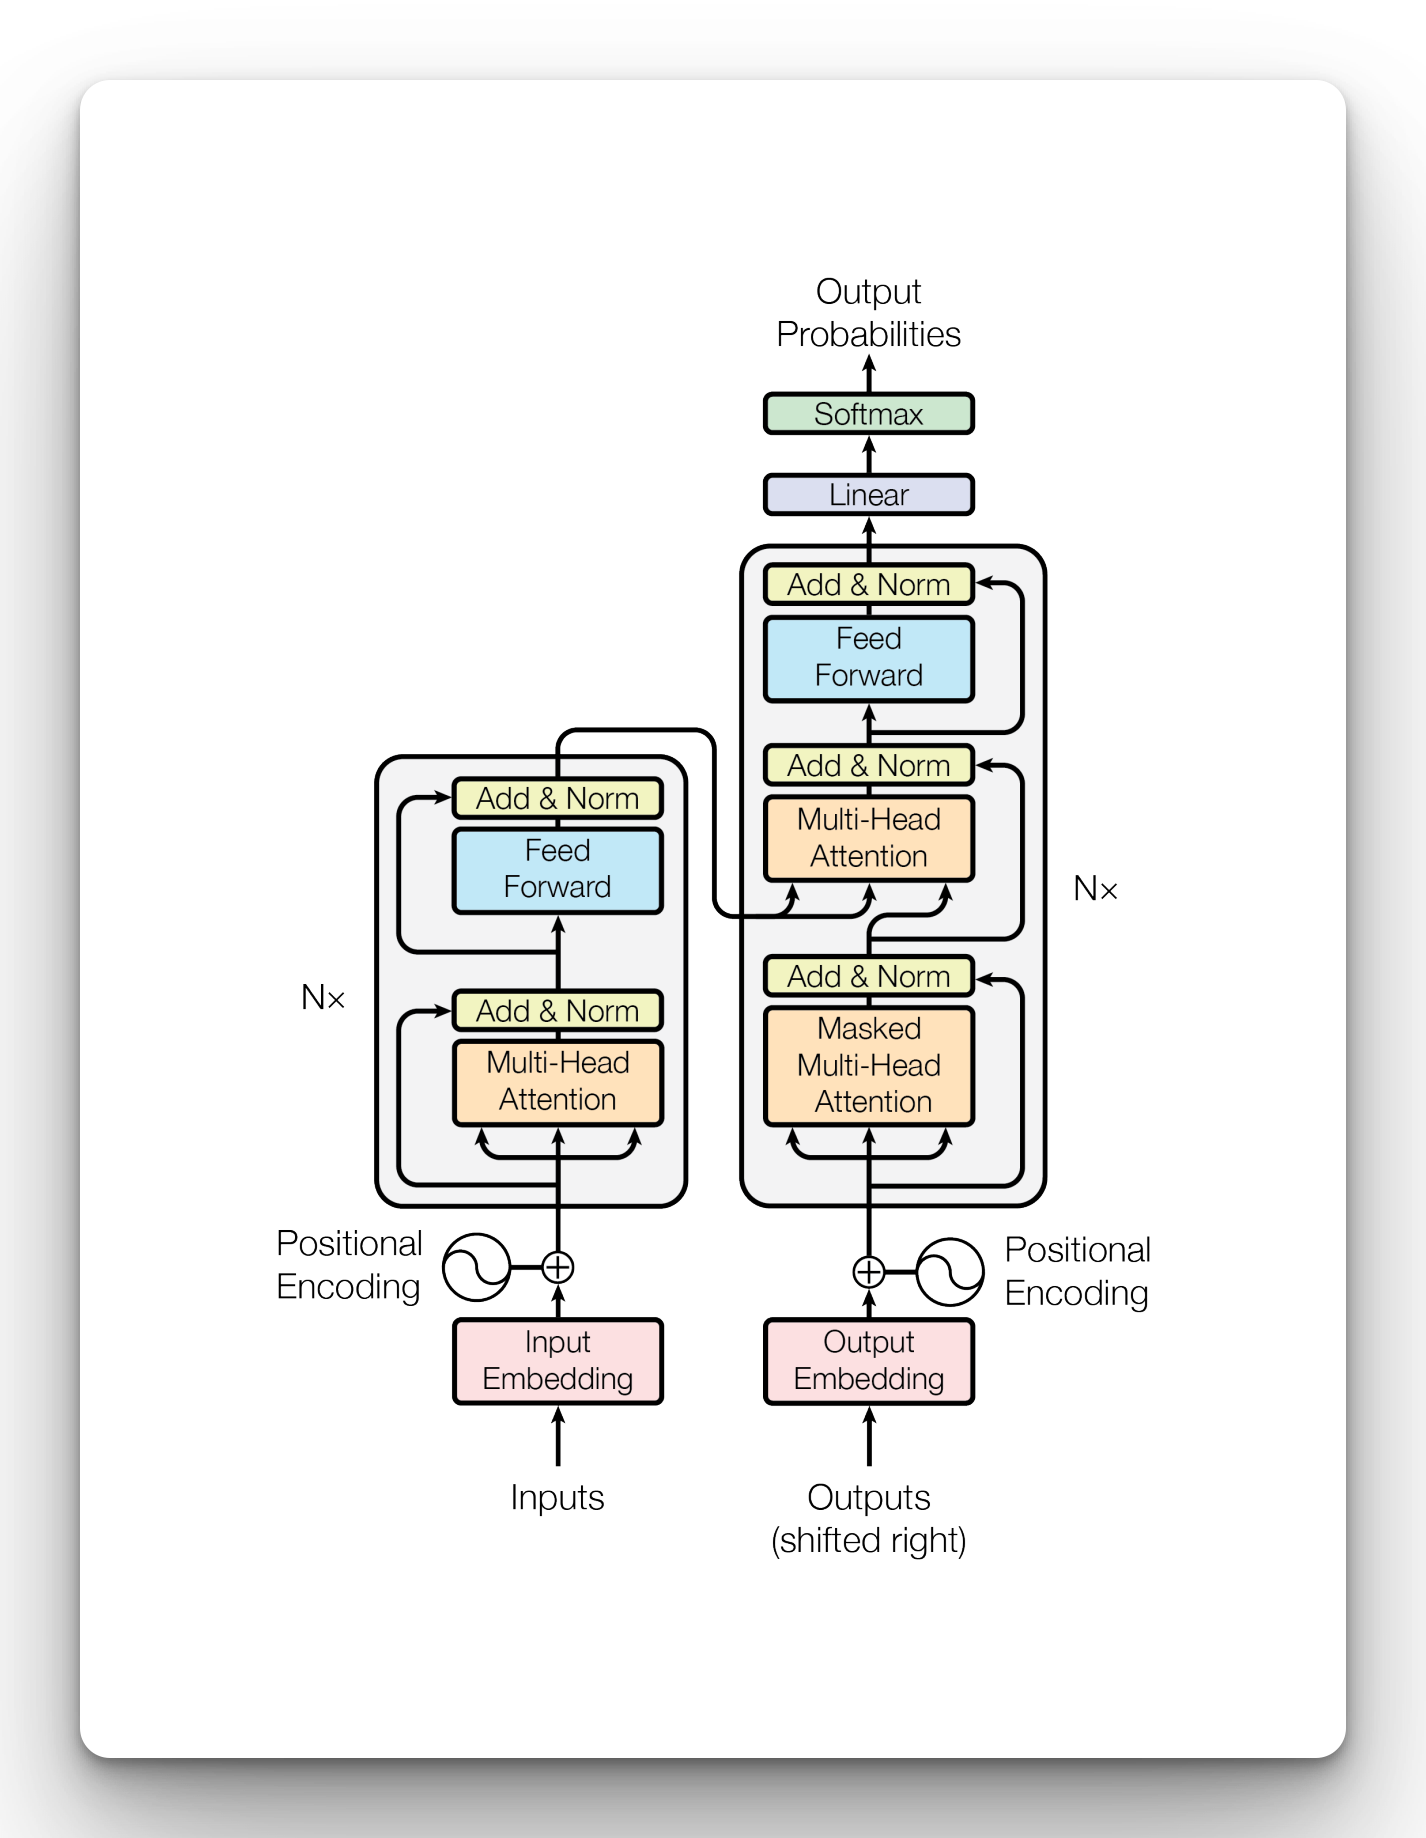

## The mathmatical trick behind self attention

In [ ]:
# ESTO ES BASTANTE TOCHO
# Multiplicar una matriz por una matriz cuadrada triangular inferior normalizada (por la izquierda)
# nos permite obtener una matriz de medias de cada fila y sus anteriores
# Este es la idea matematica importante que hay detras de los mecanismos de auto-atención
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [ ]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [ ]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)


In [ ]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

# Da false pero dan los mismo, seguramente se deba a que alguna de las dos tiene un tipo
# que almacena mas decimales

False

In [ ]:
# version 3: using softmax
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) # Matriz triangular superior de -inf, diagonal y triangular inferior 0s
# Entender los menos infinitos como la representación matricial de que el presente se comunica con el pasado
# pero no con el futuro
wei = F.softmax(wei, dim=-1) # Al hacer la softmax de una matriz con esa forma, haces como la exponencial
xbow3 = wei @ x              # llevando los -inf a 0 y los ceros a 1's y despues normalizando la fila
torch.allclose(xbow2,xbow3)

True

## Time to apply new knowledge

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

n_embd = 32

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BiagramLanguageModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Each token directly reads off the logit for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B, T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    tok_emb = self.token_embedding_table(idx) # (B,T,C)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C), al sumar abajo se añade automaticamente la dimensión de batch necesaria
    x = tok_emb + pos_emb # (B,T,C)
    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B,T) array of indices in the current context
    for _ in range(max_new_tokens):
      # get the predictions
      logits, loss = self(idx)
      # focus only on the last time step
      logits = logits[:,-1,:] # becomes (B,C), predicting based just in the immediate last prediction
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B,C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx,idx_next), dim=1) # (B, T+1)

    return idx

m = BiagramLanguageModelV2()
logits, loss = m(xb,yb)

optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
block_size = 8

for steps in range(10000):
  #sample a batch of data
  xb, yb = get_batch('train')

  #evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())

2.300748348236084


# Self attention


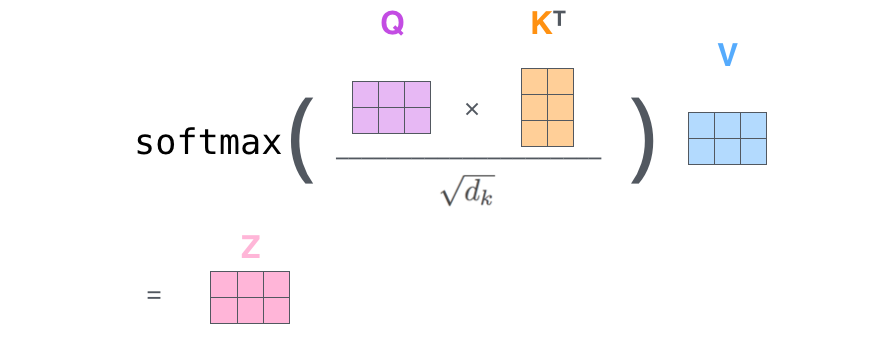

In [ ]:
# version 4: self-attention
torch.manual_seed(1337)
B,T,C = 4,8,32 #batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C,head_size, bias=False) # Al dejar el bias false, esto no deja de ser mas que una multiplicación por una matriz de pesos
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x) # (B,T,16)
q = query(x) # (B,T,16)

wei = q @ k.transpose(-2,-1) # (B,T,16) @ (B, 16, T) -------> (B, T, T)

tril = torch.tril(torch.ones(T,T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
#out = wei @ x
out = wei @ v

wei.shape, v.shape, out.shape

(torch.Size([4, 8, 8]), torch.Size([4, 8, 16]), torch.Size([4, 8, 16]))

In [ ]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [ ]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2,-1) * head_size ** -0.5 # Scalling is used to control variance specially at the initiallization

In [ ]:
k.var()

tensor(1.0449)

In [ ]:
q.var()

tensor(1.0700)

In [ ]:
wei.var()

tensor(1.0918)

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1)

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

n_embd = 32

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class Head(nn.Module):
  """ one head self-attention """
  def __init__(self, head_size):
    super().__init__()
    # Each token directly reads off the logit for the next token from a lookup table
    self.key = nn.Linear(n_embd,head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size))) # Esta variable no es un
    # parametro del módulo, para seguir las convenciones de pytorch hay que asignarselo al modulo
    # utilizando este register buffer

  def forward(self, x):
    B, T, C = x.shape

    k = self.key(x) # (B,T,C)
    q = self.query(x) # (B,T,C)
    # compute attention scores ("affinities")
    wei = q @ k.transpose(-2,-1) * C**-0.5 # (B,T,C) @ (B, C, T) -------> (B, T, T)
    wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B,T,T)
    wei = F.softmax(wei, dim=-1) #(B,T,T)
    # perform the weighted aggregation of the values
    v = self.value(x) # (B,T,C)
    out = wei @ v # (B,T,T) @ (B,T,C) ------> (B,T,C)
    return out

  def generate(self, idx, max_new_tokens):
    # idx is (B,T) array of indices in the current context
    for _ in range(max_new_tokens):
      # get the predictions
      logits, loss = self(idx)
      # focus only on the last time step
      logits = logits[:,-1,:] # becomes (B,C), predicting based just in the immediate last prediction
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B,C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx,idx_next), dim=1) # (B, T+1)

    return idx

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BiagramLanguageModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    # Each token directly reads off the logit for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.sa_head = Head(n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B, T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    tok_emb = self.token_embedding_table(idx) # (B,T,C)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C), al sumar abajo se añade automaticamente la dimensión de batch necesaria
    x = tok_emb + pos_emb # (B,T,C)
    x = self.sa_head(x)
    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B,T) array of indices in the current context
    for _ in range(max_new_tokens):
      # crop idx to the last block_size tokens
      idx_cond = idx[:, -block_size:]
      # get the predictions
      logits, loss = self(idx_cond)
      # focus only on the last time step
      logits = logits[:,-1,:] # becomes (B,C), predicting based just in the immediate last prediction
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B,C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx,idx_next), dim=1) # (B, T+1)

    return idx

m = BiagramLanguageModelV3()
logits, loss = m(xb)

optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
block_size = 8

for steps in range(10000):
  #sample a batch of data
  xb, yb = get_batch('train')

  #evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())

2.140096664428711


In [ ]:
print(decode(m.generate(torch.zeros((1,1),dtype=torch.long),max_new_tokens=100)[0].tolist()))


Gera. Y ton ele haque tastranocio es ha, etabio espoton dala a, ba sto, tandó na rque nostresãora 


## Multi Headed Self Attention


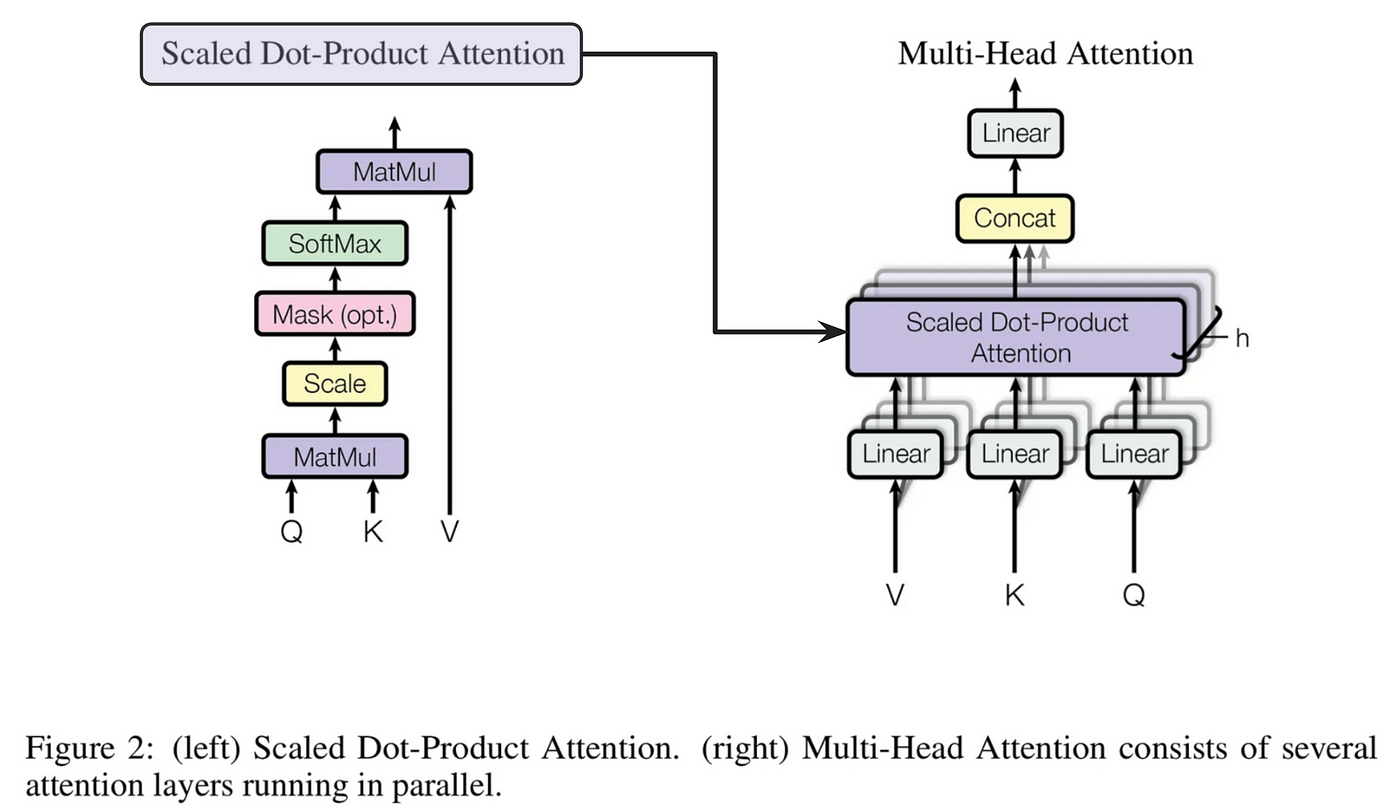

In [ ]:
class MultiHeadAttention(nn.Module):
  """ multiple heads of self attention in parallel """

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

  def forward(self, x):
    return torch.cat([h(x) for h in self.heads], dim=-1)

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BiagramLanguageModelV4(nn.Module):
  def __init__(self):
    super().__init__()
    # Each token directly reads off the logit for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.sa_heads = MultiHeadAttention(4, n_embd//4) # i.e. 4 heads of 8-dimensional self-attention,
    self.lm_head = nn.Linear(n_embd, vocab_size)     # concatenandolos tenemos los 32 del n_embd
    # Similar a las convoluciones, en lugar de tener una gran
    # convolución tenemos varias convoluciones cuyos resultados se concatenan

  def forward(self, idx, targets=None):
    B, T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    tok_emb = self.token_embedding_table(idx) # (B,T,C)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C), al sumar abajo se añade automaticamente la dimensión de batch necesaria
    x = tok_emb + pos_emb # (B,T,C)
    x = self.sa_heads(x)
    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B,T) array of indices in the current context
    for _ in range(max_new_tokens):
      # crop idx to the last block_size tokens
      idx_cond = idx[:, -block_size:]
      # get the predictions
      logits, loss = self(idx_cond)
      # focus only on the last time step
      logits = logits[:,-1,:] # becomes (B,C), predicting based just in the immediate last prediction
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B,C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx,idx_next), dim=1) # (B, T+1)

    return idx

m = BiagramLanguageModelV4()
logits, loss = m(xb)

optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
block_size = 8

for steps in range(10000):
  #sample a batch of data
  xb, yb = get_batch('train')

  #evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())

2.020937204360962


In [ ]:
print(decode(m.generate(torch.zeros((1,1),dtype=torch.long),max_new_tokens=100)[0].tolist()))


Gello lato me eshas me ya minocios señon ese que poson dela a vuentas, ́le Lunta rilo no densãora 


## Adding the Feed-Forward layer


In [ ]:
class FeedForward(nn.Module):
  """ a simple linear layer followed by a non-linearity """

  def __init__(self, num_heads):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, n_embd),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BiagramLanguageModelV5(nn.Module):
  def __init__(self):
    super().__init__()
    # Each token directly reads off the logit for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.sa_heads = MultiHeadAttention(4, n_embd//4)
    self.ffwd = FeedForward(n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B, T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    tok_emb = self.token_embedding_table(idx) # (B,T,C)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C), al sumar abajo se añade automaticamente la dimensión de batch necesaria
    x = tok_emb + pos_emb # (B,T,C)
    x = self.sa_heads(x)
    x = self.ffwd(x) # (B,T,C)
    # Para que nos entendamos el feed-forward se hace a nivel de token todos lo hacen de manera independiente.
    # El módulo de self-attention es el de comunicación entre los tokens, que una vez a acumulado toda la información
    # da paso a que cada token individualmente reflexione acerca de esa información.
    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B,T) array of indices in the current context
    for _ in range(max_new_tokens):
      # crop idx to the last block_size tokens
      idx_cond = idx[:, -block_size:]
      # get the predictions
      logits, loss = self(idx_cond)
      # focus only on the last time step
      logits = logits[:,-1,:] # becomes (B,C), predicting based just in the immediate last prediction
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B,C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx,idx_next), dim=1) # (B, T+1)

    return idx

m = BiagramLanguageModelV5()
logits, loss = m(xb)

optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
block_size = 8

for steps in range(10000):
  #sample a batch of data
  xb, yb = get_batch('train')

  #evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())

1.9370359182357788


In [ ]:
print(decode(m.generate(torch.zeros((1,1),dtype=torch.long),max_new_tokens=100)[0].tolist()))


ramo cuda quido lu estombo trón tomó monde ejo dosteros, vieno y Marmes, abrrando vue, berzo, señ


## Transformer Blocks

In [ ]:
class Block(nn.Module):
  """ Transformer block: communication (multi head self-attention) followed by computation (feed-forward) """

  def __init__(self, n_embd, n_head):
    # n_embd: embedding dimensions n_head: the number of heads we'd like
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)

  def forward(self, x):
    x = self.sa(x)
    x = self.ffwd(x)
    return x

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BiagramLanguageModelV6(nn.Module):
  def __init__(self):
    super().__init__()
    # Each token directly reads off the logit for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.blocks = nn.Sequential(
        Block(n_embd, n_head = 4), # Elegimos 4 por que como n_embd era 32, asi hacemos que
        Block(n_embd, n_head = 4), # head_size sea 8 y todo quede bien cuadrado
        Block(n_embd, n_head = 4),
    )
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B, T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    tok_emb = self.token_embedding_table(idx) # (B,T,C)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C), al sumar abajo se añade automaticamente la dimensión de batch necesaria
    x = tok_emb + pos_emb # (B,T,C)
    x = self.blocks(x)
    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B,T) array of indices in the current context
    for _ in range(max_new_tokens):
      # crop idx to the last block_size tokens
      idx_cond = idx[:, -block_size:]
      # get the predictions
      logits, loss = self(idx_cond)
      # focus only on the last time step
      logits = logits[:,-1,:] # becomes (B,C), predicting based just in the immediate last prediction
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B,C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx,idx_next), dim=1) # (B, T+1)

    return idx

m = BiagramLanguageModelV6()
logits, loss = m(xb)

optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
block_size = 8

for steps in range(10000):
  #sample a batch of data
  xb, yb = get_batch('train')

  #evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())

2.004695415496826


In [ ]:
# Como podemos ver los resultados no son de la calidad deseada, seguramente esto se deba a
# que cuando empezamos a trabajar con redes neuronales de un cierto nivel de profundida
# empiezan a surgir importante problemas de optimización.
print(decode(m.generate(torch.zeros((1,1),dtype=torch.long),max_new_tokens=100)[0].tolist()))


é́lleste, dí davorios, y buelor poro cala, ceños eson Quuiejos Sega: y talconado y que lo deguera


## Transformer Optimizations Tweaks

### Residual/Skip Connections

Basically they are connections that add the previous value of a certain path before a computation is performed to the resulting value of the computation. Remember that addition distributes gradients equally to both of its branches that feed the input, so while in initialiation they barely don't have any weight, they end up working as some kind of "straight forward highway" to the optimizer from the target all down to the input.




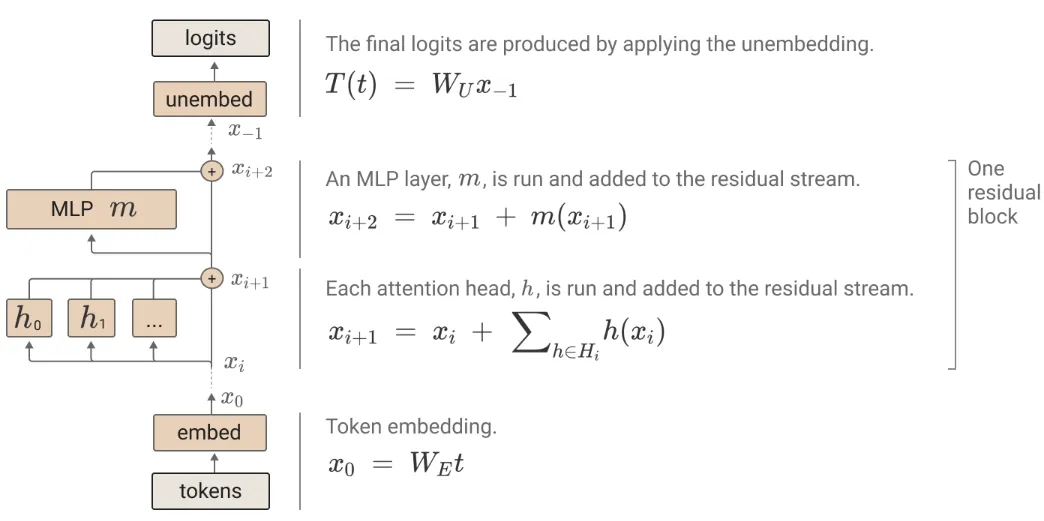

In [ ]:
class MultiHeadAttention(nn.Module):
  """ multiple heads of self attention in parallel """

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd) # Projection

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.proj(out) # The projection is just a linear transformation of the output of the upper layer,
    return out           # it will be poured into the residual pathway

In [ ]:
class FeedForward(nn.Module):
  """ a simple linear layer followed by a non-linearity """

  def __init__(self, num_heads):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4*n_embd), # Another optimization tweak from the transformer introductory paper is that
        nn.ReLU(), # in the feed-forward layer it's inner layer should be multiplied by 4 in terms of channel sizes
        nn.Linear(4*n_embd, n_embd), # Projection layer going back into the residual pathway
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
class Block(nn.Module):
  """ Transformer block: communication (multi head self-attention) followed by computation (feed-forward) """

  def __init__(self, n_embd, n_head):
    # n_embd: embedding dimensions n_head: the number of heads we'd like
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)

  def forward(self, x):
    x = x + self.sa(x)
    x = x + self.ffwd(x)
    return x

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BiagramLanguageModelV7(nn.Module):
  def __init__(self):
    super().__init__()
    # Each token directly reads off the logit for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.blocks = nn.Sequential(
        Block(n_embd, n_head = 4), # Elegimos 4 por que como n_embd era 32, asi hacemos que
        Block(n_embd, n_head = 4), # head_size sea 8 y todo quede bien cuadrado
        Block(n_embd, n_head = 4),
    )
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B, T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    tok_emb = self.token_embedding_table(idx) # (B,T,C)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C), al sumar abajo se añade automaticamente la dimensión de batch necesaria
    x = tok_emb + pos_emb # (B,T,C)
    x = self.blocks(x)
    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B,T) array of indices in the current context
    for _ in range(max_new_tokens):
      # crop idx to the last block_size tokens
      idx_cond = idx[:, -block_size:]
      # get the predictions
      logits, loss = self(idx_cond)
      # focus only on the last time step
      logits = logits[:,-1,:] # becomes (B,C), predicting based just in the immediate last prediction
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B,C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx,idx_next), dim=1) # (B, T+1)

    return idx

m = BiagramLanguageModelV7()
logits, loss = m(xb)

optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
block_size = 8

for steps in range(5000):
  #sample a batch of data
  xb, yb = get_batch('train')

  #evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())

1.8551212549209595


In [ ]:
print(decode(m.generate(torch.zeros((1,1),dtype=torch.long),max_new_tokens=100)[0].tolist()))


 Diollos, porque
Cocilu, que señió el Moligar ni se tu pasestur ahorura mirad de su a mucho, quito


### Layer Normalization


Interesting to note that there had not been many deviations from the original transformer paper in last 5 years but one of the important ones has to do with this optimization trick.

In the original transformer formulation, layer normalization was performed after every transformation, known as post-norm formulation. Today the sta suggests that pre-norm formulation performs better, that's what we are going to implement right now.

In [ ]:
class Block(nn.Module):
  """ Transformer block: communication (multi head self-attention) followed by computation (feed-forward) """

  def __init__(self, n_embd, n_head):
    # n_embd: embedding dimensions n_head: the number of heads we'd like
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BiagramLanguageModelV8(nn.Module):
  def __init__(self):
    super().__init__()
    # Each token directly reads off the logit for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.blocks = nn.Sequential(
        Block(n_embd, n_head = 4), # Elegimos 4 por que como n_embd era 32, asi hacemos que
        Block(n_embd, n_head = 4), # head_size sea 8 y todo quede bien cuadrado
        Block(n_embd, n_head = 4),
        nn.LayerNorm(n_embd),
    )
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B, T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    tok_emb = self.token_embedding_table(idx) # (B,T,C)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C), al sumar abajo se añade automaticamente la dimensión de batch necesaria
    x = tok_emb + pos_emb # (B,T,C)
    x = self.blocks(x)
    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B,T) array of indices in the current context
    for _ in range(max_new_tokens):
      # crop idx to the last block_size tokens
      idx_cond = idx[:, -block_size:]
      # get the predictions
      logits, loss = self(idx_cond)
      # focus only on the last time step
      logits = logits[:,-1,:] # becomes (B,C), predicting based just in the immediate last prediction
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B,C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx,idx_next), dim=1) # (B, T+1)

    return idx

m = BiagramLanguageModelV8()
logits, loss = m(xb)

optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
block_size = 8

for steps in range(5000):
  #sample a batch of data
  xb, yb = get_batch('train')

  #evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())

1.7760682106018066


In [ ]:
print(decode(m.generate(torch.zeros((1,1),dtype=torch.long),max_new_tokens=100)[0].tolist()))


 Diós y encriga
de vuu, que se querza gno de lo deste y pasas, enas que lo recedios ver la mido que


## Scalling up the model

### Adding Dropout

Dropout basically takes your NN and randomly, every forward/backward pass, shuts off some subset of neturons randomly dropping them to zero.

What this does effectively is, because the mask of what's been drop out is changing with every forward/backward pass, kind of training an ensemble of sub-networks and then when everything is again fully enabled all of those sub-networks end up merged into one single ensemble.


In [12]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

# Hyperparameters
batch_size = 64
block_size = 256 # This is 256 characters of context to predict the 257th character
max_iters = 1000
eval_interval = 500
learning_rate = 3e-4
eval_iters = 200
n_embd = 384 # 384/6 -----> every head is 64 dimensional as it is a standard
n_head = 6
n_layer = 6
dropout = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Dataset to feed transformers
!wget https://gist.githubusercontent.com/jsdario/6d6c69398cb0c73111e49f1218960f79/raw/8d4fc4548d437e2a7203a5aeeace5477f598827d/el_quijote.txt

--2024-02-21 14:22:38--  https://gist.githubusercontent.com/jsdario/6d6c69398cb0c73111e49f1218960f79/raw/8d4fc4548d437e2a7203a5aeeace5477f598827d/el_quijote.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1060259 (1.0M) [text/plain]
Saving to: ‘el_quijote.txt’

el_quijote.txt      100%[===================>]   1.01M  --.-KB/s    in 0.03s   

2024-02-21 14:22:38 (37.9 MB/s) - ‘el_quijote.txt’ saved [1060259/1060259]



In [3]:
with open('el_quijote.txt', 'r', encoding = 'utf-8') as f:
  text = f.read()

In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype = torch.long)

n = int(0.9*len(data))
train_data = data[:n]
test_data = data[n:]

def get_batch(split):
  # Generate a small batch of data of inputs x and targets y
  data = train_data if split == 'train' else test_data
  ix = torch.randint(len(data)-block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])
  x, y = x.to(device), y.to(device)
  return x,y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

xb, yb = get_batch('train')

In [5]:
class Head(nn.Module):
  """ one head self-attention """
  def __init__(self, head_size):
    super().__init__()
    # Each token directly reads off the logit for the next token from a lookup table
    self.key = nn.Linear(n_embd,head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size))) # Esta variable no es un
    # parametro del módulo, para seguir las convenciones de pytorch hay que asignarselo al modulo
    # utilizando este register buffer

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B, T, C = x.shape

    k = self.key(x) # (B,T,C)
    q = self.query(x) # (B,T,C)
    # compute attention scores ("affinities")
    wei = q @ k.transpose(-2,-1) * C**-0.5 # (B,T,C) @ (B, C, T) -------> (B, T, T)
    wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B,T,T)
    wei = F.softmax(wei, dim=-1) #(B,T,T)
    wei = self.dropout(wei) # This is to randomly prevent some nodes to communicate
    v = self.value(x) # (B,T,C)
    out = wei @ v # (B,T,T) @ (B,T,C) ------> (B,T,C)
    return out

  def generate(self, idx, max_new_tokens):
    # idx is (B,T) array of indices in the current context
    for _ in range(max_new_tokens):
      # get the predictions
      logits, loss = self(idx)
      # focus only on the last time step
      logits = logits[:,-1,:] # becomes (B,C), predicting based just in the immediate last prediction
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B,C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx,idx_next), dim=1) # (B, T+1)

    return idx

In [6]:
class MultiHeadAttention(nn.Module):
  """ multiple heads of self attention in parallel """

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd) # Projection
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out)) # The projection is just a linear transformation of the output of the upper layer,
    return out           # it will be poured into the residual pathway

In [7]:
class FeedForward(nn.Module):
  """ a simple linear layer followed by a non-linearity """

  def __init__(self, num_heads):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4*n_embd),
        nn.ReLU(),
        nn.Linear(4*n_embd, n_embd),
        nn.Dropout(dropout), # Dropout it's something you can add right before the connection adds back with the
        # residual pathway
    )

  def forward(self, x):
    return self.net(x)

In [8]:
class Block(nn.Module):
  """ Transformer block: communication (multi head self-attention) followed by computation (feed-forward) """

  def __init__(self, n_embd, n_head):
    # n_embd: embedding dimensions n_head: the number of heads we'd like
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x

In [9]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class TransformerModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Each token directly reads off the logit for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.blocks = nn.Sequential(*[Block(n_embd, n_head = n_head) for _ in range(n_layer)])
    self.ln_f = nn.LayerNorm(n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B, T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    tok_emb = self.token_embedding_table(idx) # (B,T,C)
    pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C), al sumar abajo se añade automaticamente la dimensión de batch necesaria
    x = tok_emb + pos_emb # (B,T,C)
    x = self.blocks(x)
    x = self.ln_f(x)
    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B,T) array of indices in the current context
    for _ in range(max_new_tokens):
      # crop idx to the last block_size tokens
      idx_cond = idx[:, -block_size:]
      # get the predictions
      logits, loss = self(idx_cond)
      # focus only on the last time step
      logits = logits[:,-1,:] # becomes (B,C), predicting based just in the immediate last prediction
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B,C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx,idx_next), dim=1) # (B, T+1)

    return idx

model = TransformerModel()
m = model.to(device)
logits, loss = m(xb)

optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [15]:
for steps in range(max_iters):

  # every once in a while evaluate the loss on train and val sets
  """if steps % eval_interval == 0 or iter == max_iters - 1:
      losses = estimate_loss()
      print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")"""

  #sample a batch of data
  xb, yb = get_batch('train')

  #evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()
  print(steps)

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

-Y ¿más saldrán -repligado don Quijote, tan maldicientes robispo el ventero.
No sé yo –respondió Sancho Panza; pero no me acuerdo yo, mi parecer, que tenga, te podría yo vendrá acertada del alto que hizo hallarle, que
después de se hallar un mal a dociento, primero de dos tres cuatro medio dio de las velas. Esto aparto se podía resistiría y acometer su amigo, y así, no me dejase ni acometer en las aventuras que comenzar, como el toque ha dicho puedas ser poner mi ofinitali(ningún los pecados pusillas, adurriera de probar no huidondas de poder libre), por menostrar descubiertos de la verdad de su hermosura, me faltan, le como en efeto, y nojadas el que a mí mismo pueden. Y una delante, que nos vaya los libros peligros de caballerías, y cómo lo profetan a gusto se gueran, pues de modo, él se modara a ella. Siendo más, nube bien a mitarla, inten a mi y pesadille fui y hendir cautiva, que él, y no por acabada la diligencia de la hermosa infacernecera, por ser e írades bla

In [16]:
# To evaluate loss after last training iteration made
losses = estimate_loss()
print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

step <built-in function iter>: train loss 0.8348, val loss 1.2799


In [17]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


–Melacó el cristiana. Él resspondió Sancho–, y tomó Anselmo que por él, y dijo a Camila en la casa y muy a decirle:
-Señor, yo al romar en este tan mal el cual veo y el mesmo sin favorable todo el librillo todo sucedido tudo, pusiese al gallardo hombre y gran honesteríos. Dígolo por fue haberla sido tal.
Congojóse Constantino bonetido todos a los caliente y honrados y muestran los pies de Felión, le dijo:
–Señor, que fe di, las sóleras puestas y las cinchas que son las prúblicas y librementes en el tiempo de sus padres. Y a esto doy ahora hablara Dorotea en ella y cebada entre las donde las dos habían oído, porque dejando, cuando allí vuelto a su doncella, llegué a todos, y así, dijo:
–Esto, como tú dinero –dijo, dijo Sancho Panza:
–Sabed, hermano, que os quiere.
–Y veaa y bien la honras o vuestra galama y con señor, mi Camila, es señor don Berbiarreo que son la vela, consijoses y posible mi vía; pero, por lo mismo, que entender que, cuando, con midencia cencia d

# Some theoretycal snippets


## Encoder vs Decoder vs Both

What we implemented here is a decoder only transformer, so there's not encoder part and there's not cross attention and the correspondent block in the decoder.

Decoder only models function well when we are just generating text and it's unconditioned on anything, we are just blabbering on according to a certein dataset. What makes our model a decoder is the using of the triangular mask in our Transformer, so it has that autoregresive property where we can just go and sample from it. Decoder architectures are good for language modeling.

The reason why the original paper has an encoder-decoder architecture is because it's a machine translation paper, the setting is totally different, it expects that encode for example French and it's expected to decode the translation in English. The encoder reads the part in French and similarly to our work the tokens go through a transformer, but in this case with no triangular masking, so all the tokens are allowed to communicate with eachother as much as they want, encoding whatever is the content of the French text. This encoded tokens are sent in the end to the decoder wich does the language modeling, wich will have an additional connection to the outputs of the encoder, the cross attention block. The queries are still generated from X but now the keys and the values are comming from the top generated by the nodes that came outside of the encoder. With all of this, it's conditioning the decoding not just on the past of the current decoding but also on having seen the fully encoded French prompt.